In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon
from shapely.ops import unary_union
import networkx as nx

# Perímetros intercensitários (PICs)

## Explicação inicial e demonstração

A ideia é reproduzir a proposta abaixo, utilizando apenas a interseção entre os setores como fonte para o grafo.

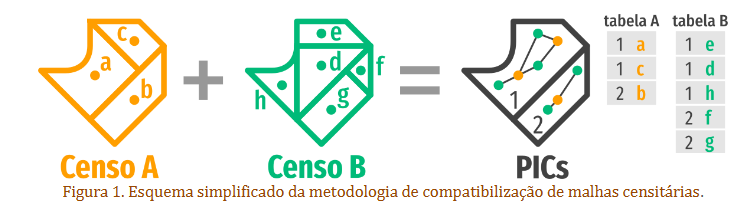

Para demonstrar o algoritmo, vamos utilizar um conjunto de geometrias de exemplo.

In [2]:
# Create geometries for set A
poly_a1 = Polygon([(0, 0), (2, 0), (2, 2), (0, 2)])
poly_a2 = Polygon([(2, 0), (4, 0), (4, 2), (2, 2)])
poly_a3 = Polygon([(4, 0), (6, 0), (6, 2), (4, 2)])
poly_a4 = Polygon([(0, 2), (6, 2), (6, 4), (0, 4)])

# Create geometries for set B
poly_b1 = Polygon([(0, 0), (3, 0), (3, 2), (0, 2)])
poly_b2 = Polygon([(3, 0), (6, 0), (6, 2), (3, 2)])
poly_b3 = Polygon([(0, 2), (3, 2), (3, 4), (0, 4)])
poly_b4 = Polygon([(3, 2), (6, 2), (6, 4), (3, 4)])

# Create GeoDataFrames
gdf_a = gpd.GeoDataFrame({'geometry': [poly_a1, poly_a2, poly_a3, poly_a4], 'id': [f'A{i}' for i in range(1,5)]})
gdf_b = gpd.GeoDataFrame({'geometry': [poly_b1, poly_b2, poly_b3, poly_b4], 'id': [f'B{i}' for i in range(1,5)]})

<Axes: >

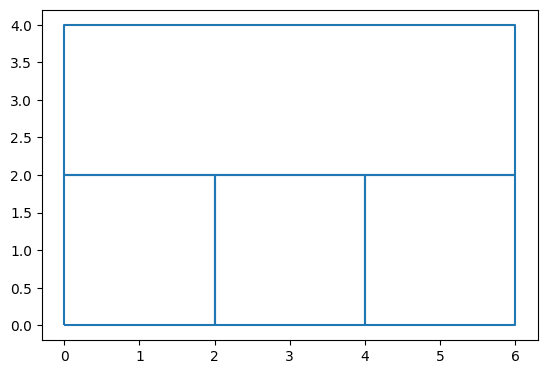

In [3]:
gdf_a.boundary.plot()

<Axes: >

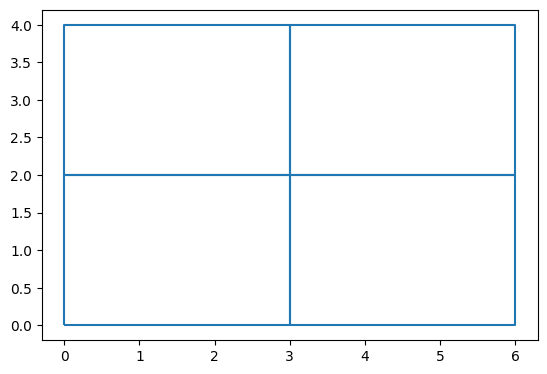

In [4]:
gdf_b.boundary.plot()

Nesse caso, o resultado desejado é um conjunto de dois retângulos, um de (0,0) a (6,2), e outro de (0,2) a (6,4).

Primeiro, precisamos encontrar as interseções entre as geometrias dos dataframes diferentes.

In [5]:
intersections = gpd.overlay(gdf_a, gdf_b, how='intersection', keep_geom_type=True)
intersections = intersections.reset_index()
intersections

,index,id_1,id_2,geometry
0,0,A1,B1,"POLYGON ((0.00000 0.00000, 0.00000 2.00000, 2...."
1,1,A2,B1,"POLYGON ((2.00000 0.00000, 2.00000 2.00000, 3...."
2,2,A2,B2,"POLYGON ((3.00000 0.00000, 3.00000 2.00000, 4...."
3,3,A3,B2,"POLYGON ((4.00000 0.00000, 4.00000 2.00000, 6...."
4,4,A4,B3,"POLYGON ((0.00000 2.00000, 0.00000 4.00000, 3...."
5,5,A4,B4,"POLYGON ((3.00000 2.00000, 3.00000 4.00000, 6...."


<Axes: >

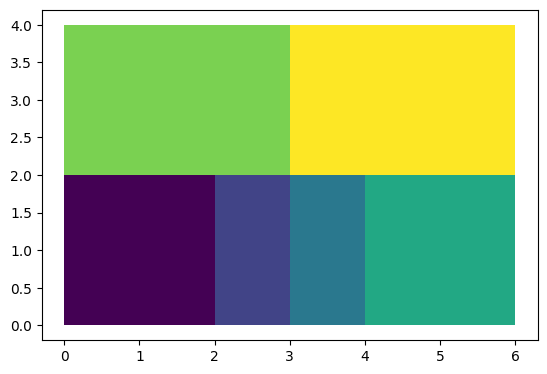

In [6]:
intersections.plot(column='index')

Agora, utilizamos as interseções encontradas para gerar os grafos de relação.

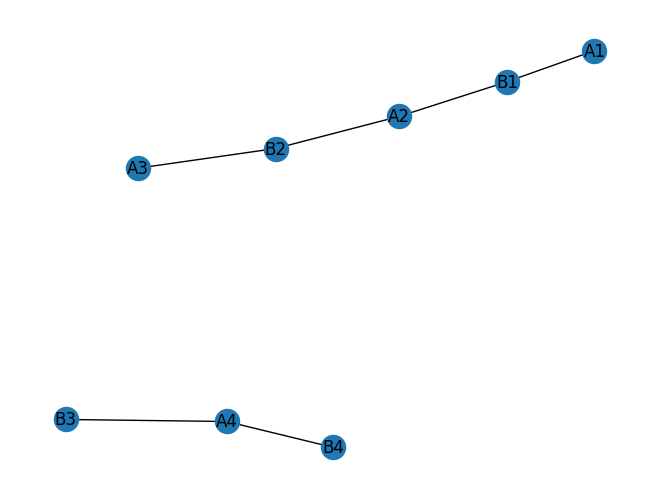

In [7]:
# Generate graph from the DataFrame
G = nx.from_pandas_edgelist(intersections[['id_1', 'id_2']], 'id_1', 'id_2')
nx.draw(G, with_labels=True)

Então, utilizamos os conjuntos de nós conectados para criar um novo dataframe.

In [8]:
connected_components = list(nx.connected_components(G))
rl_df = pd.DataFrame({'set': connected_components})
rl_df

,set
0,"{A1, A3, A2, B1, B2}"
1,"{B4, B3, A4}"


Para simplificar, vamos utilizar uma coluna de identificador numérico baseada no index.

In [9]:
rl_df = rl_df.reset_index()
rl_df['index'] = rl_df['index'] + 1
rl_df = rl_df.rename(columns={'index': 'pics'})
rl_df

,pics,set
0,1,"{A1, A3, A2, B1, B2}"
1,2,"{B4, B3, A4}"


Por último, vamos gerar um registro para cada item do conjunto de nós, de modo que este dataset se torna uma tabela associativa entre geometrias iniciais e "PICs".

In [10]:
rl_df = rl_df.explode('set')
rl_df = rl_df.rename(columns={'set':'item'})
rl_df

,pics,item
0,1,A1
0,1,A3
0,1,A2
0,1,B1
0,1,B2
1,2,B4
1,2,B3
1,2,A4


Finalmente, agregamos o identificador do PIC no dataframe de interseções.

In [11]:
intersections = intersections.merge(rl_df, how='left', left_on='id_1', right_on='item')
intersections

,index,id_1,id_2,geometry,pics,item
0,0,A1,B1,"POLYGON ((0.00000 0.00000, 0.00000 2.00000, 2....",1,A1
1,1,A2,B1,"POLYGON ((2.00000 0.00000, 2.00000 2.00000, 3....",1,A2
2,2,A2,B2,"POLYGON ((3.00000 0.00000, 3.00000 2.00000, 4....",1,A2
3,3,A3,B2,"POLYGON ((4.00000 0.00000, 4.00000 2.00000, 6....",1,A3
4,4,A4,B3,"POLYGON ((0.00000 2.00000, 0.00000 4.00000, 3....",2,A4
5,5,A4,B4,"POLYGON ((3.00000 2.00000, 3.00000 4.00000, 6....",2,A4


<Axes: >

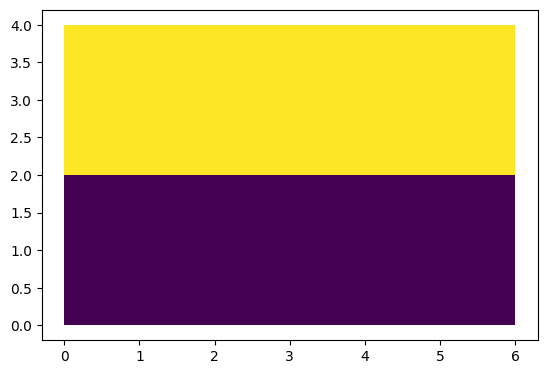

In [12]:
intersections.plot(column='pics')

E geramos um dataset final, apenas com o identificador dos PICs e as respectivas geometrias.

In [13]:
final_gdf = intersections[['pics', 'geometry']].dissolve('pics')
final_gdf = final_gdf.reset_index()
final_gdf

,pics,geometry
0,1,"POLYGON ((2.00000 2.00000, 3.00000 2.00000, 4...."
1,2,"POLYGON ((0.00000 4.00000, 3.00000 4.00000, 6...."


<Axes: >

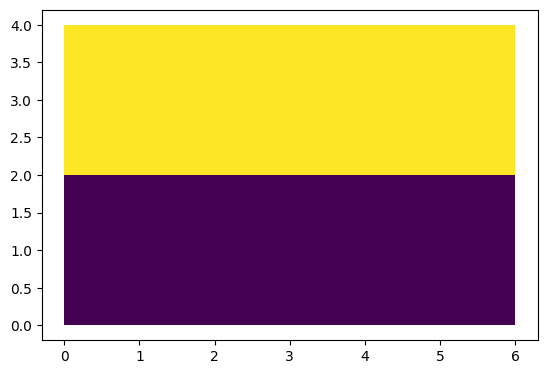

In [14]:
final_gdf.plot('pics')

## Generalização em uma função

In [15]:
def minimum_intergeometry_boundaries(df:gpd.GeoDataFrame, other:gpd.GeoDataFrame, df_id_col:str=None, other_id_col:str=None) -> gpd.GeoDataFrame:
    if df_id_col == None:
        df = df.reset_index().copy()
        df_id_col = df.columns[0]
    if other_id_col == None:
        other = other.reset_index().copy()
        other_id_col = other.columns[0]
    if df_id_col == other_id_col:
        df_id_col = df_id_col + '_1'
        other_id_col = other_id_col + '_2'
    intersections = gpd.overlay(df, other, how='intersection', keep_geom_type=True)
    G = nx.from_pandas_edgelist(intersections[[df_id_col, other_id_col]], df_id_col, other_id_col)
    connected_components = list(nx.connected_components(G))
    rl_df = pd.DataFrame({'set': connected_components})
    rl_df = rl_df.reset_index()
    rl_df['index'] = rl_df['index'] + 1
    rl_df = rl_df.rename(columns={'index': 'pics'})
    rl_df = rl_df.explode('set')
    rl_df = rl_df.rename(columns={'set':'item'})
    intersections = intersections.merge(rl_df, how='left', left_on='id_1', right_on='item')
    final_gdf = intersections[['pics', 'geometry']].dissolve('pics')
    final_gdf = final_gdf.reset_index()
    return final_gdf

In [16]:
minimum_intergeometry_boundaries(gdf_a, gdf_b, 'id', 'id')

,pics,geometry
0,1,"POLYGON ((2.00000 2.00000, 3.00000 2.00000, 4...."
1,2,"POLYGON ((0.00000 4.00000, 3.00000 4.00000, 6...."


<Axes: >

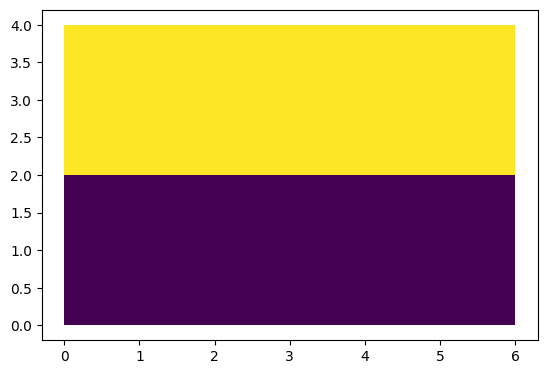

In [17]:
minimum_intergeometry_boundaries(gdf_a, gdf_b, 'id', 'id').plot(column='pics')